# Ensemble Methods(to predict the plane engine type based on the provided information)

Here we are going to use plane.csv dataset. The dataset has information about different types of airplanes, including the number of tails, year of production, type, manufacturer, model, number of engines, seat, speed, and engine type. we will train a classifier to predict the engine type based on the provided information.

In [176]:

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
features = pd.read_csv('data/planes.csv')
features

,tailnum,year,type,manufacturer,model,engines,seats,speed,engine
0,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2,55,NaN,Turbo-fan
1,N102UW,1998.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
2,N103US,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
3,N104UW,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
4,N10575,2002.0,Fixed wing multi engine,EMBRAER,EMB-145LR,2,55,NaN,Turbo-fan
...,...,...,...,...,...,...,...,...,...
3317,N997AT,2002.0,Fixed wing multi engine,BOEING,717-200,2,100,NaN,Turbo-fan
3318,N997DL,1992.0,Fixed wing multi engine,MCDONNELL DOUGLAS AIRCRAFT CO,MD-88,2,142,NaN,Turbo-fan
3319,N998AT,2002.0,Fixed wing multi engine,BOEING,717-200,2,100,NaN,Turbo-fan
3320,N998DL,1992.0,Fixed wing multi engine,MCDONNELL DOUGLAS CORPORATION,MD-88,2,142,NaN,Turbo-jet


## Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tailnum       3322 non-null   object 
 1   year          3252 non-null   float64
 2   type          3322 non-null   object 
 3   manufacturer  3322 non-null   object 
 4   model         3322 non-null   object 
 5   engines       3322 non-null   int64  
 6   seats         3322 non-null   int64  
 7   speed         23 non-null     float64
 8   engine        3322 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 233.7+ KB


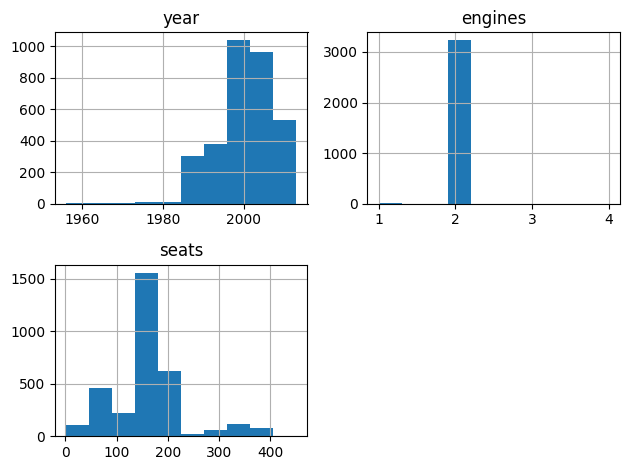

,year,engines,seats
year,1.000000,0.076068,-0.072040
engines,0.076068,1.000000,0.137073
seats,-0.072040,0.137073,1.000000


In [177]:
features.info()
features.describe()
features.isnull().sum()
features.dropna(subset=['year'], axis=0, inplace=True)
features.isnull().sum()
#Speed column is dropped here as it contains "NaN" value for most of the rows
features.drop(['speed'], axis=1, inplace=True)
features[['year', 'engines', 'seats']].hist(bins=10)
plt.tight_layout()
plt.show()

correlation = features.corr()
correlation

## Data Preparation

We are going to prepare the data by encoding the categorical features in the dataset into ordinal features using the Ordinal Encoder.

In [178]:
from sklearn.preprocessing import OrdinalEncoder
categs_feats = features[['tailnum', 'type', 'manufacturer', 'model']]
encoder = OrdinalEncoder()
categs_encoded = encoder.fit_transform(categs_feats)
features[['tailnum', 'type', 'manufacturer', 'model']] = pd.DataFrame(categs_encoded, columns=categs_feats.columns, index=categs_feats.index)
features.head()

from sklearn.preprocessing import LabelEncoder
engine_feat = features[['engine']]
label_encoder = LabelEncoder()
engine_encoded = label_encoder.fit_transform(engine_feat)
features['engine'] = pd.DataFrame(engine_encoded, columns=engine_feat.columns, index=engine_feat.index)
features.head()

import numpy as np
X = features.drop('engine', axis=1)
y = features['engine']
X

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

X.shape
y.shape

(3252,)

## Voting Ensemble

Hard voting ensemble is applied using k-Nearest Neighbors, SVM, and Logistic Regression. We are not doing any fine tuning here.

In [180]:
# Your code here
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(random_state=1)
cv_result = cross_validate(sgd_model, X, y, cv=5)
cv_result
scores = cv_result["test_score"]
print("The mean cross-validation(SGD) accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")



from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
cv_result = cross_validate(nb_model, X, y, cv=5)
cv_result
scores = cv_result["test_score"]
print("The mean cross-validation(Naive Bayes) accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")



from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier

voting_classifier = VotingClassifier(
    
estimators=[('knn', knn_model),
                ('svc', svm_model),
                ('log_reg', lr_model),
                ('sgd', sgd_model),
                ('gnb', nb_model)], 
voting='hard')


cv_result = cross_validate(voting_classifier, X, y, cv=5)
cv_result
scores = cv_result["test_score"]
print("The mean cross-validation(Hard voting using 5 individuals) accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

#Yes imporvement is visible for using 5 individuals

The mean cross-validation(SGD) accuracy is: 0.835 +/- 0.001
The mean cross-validation(Naive Bayes) accuracy is: 0.835 +/- 0.002
The mean cross-validation(Hard voting using 5 individuals) accuracy is: 0.838 +/- 0.006


In [181]:
# Your code here
voting_classifier = VotingClassifier(
    
estimators=[('knn', knn_model),
                ('gnb', nb_model),
                ('log_reg', lr_model)], 
voting='soft')

cv_result = cross_validate(voting_classifier, X, y, cv=5)
scores = cv_result["test_score"]
print("The mean cross-validation(Soft voting using 3 individuals) accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

The mean cross-validation(Soft voting using 3 individuals) accuracy is: 0.859 +/- 0.047


## Bagging Ensemble


In [182]:

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagging_classifier = BaggingClassifier(
      DecisionTreeClassifier(class_weight='balanced'),
    max_samples=0.5, max_features=0.5, bootstrap=True
)

cv_result = cross_validate(bagging_classifier, X, y, cv=5)
scores = cv_result["test_score"]
print("The mean cross-validation(Bagging(bootstrapping)) accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")



bagging_classifier = BaggingClassifier(
      DecisionTreeClassifier(class_weight='balanced'),
    max_samples=0.5, max_features=0.5, bootstrap=False
)

cv_result = cross_validate(bagging_classifier, X, y, cv=5)
scores = cv_result["test_score"]
print("The mean cross-validation(Bagging(pasting)) accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")


The mean cross-validation(Bagging(bootstrapping)) accuracy is: 0.841 +/- 0.104
The mean cross-validation(Bagging(pasting)) accuracy is: 0.834 +/- 0.063


In [183]:

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

bagging_classifier = BaggingClassifier(
      DecisionTreeClassifier(class_weight='balanced'),
    max_samples=0.5, max_features=0.5, bootstrap=False
)

hyper_grid = {
'max_samples' : [0.10, 0.30, 0.50, 0.8, 1.00]
}
grid_search = GridSearchCV(bagging_classifier, hyper_grid, scoring='accuracy')

cv_result = cross_validate(grid_search, X, y, cv=5)

scores = cv_result["test_score"]

print("The mean cross-validation(Grid search-using pasting as better) accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

The mean cross-validation(Grid search-using pasting as better) accuracy is: 0.829 +/- 0.070


## Boosting Ensemble

In [184]:
from sklearn.ensemble import GradientBoostingClassifier

grad_boost_classifier = GradientBoostingClassifier(
                        n_estimators=500, 
                        learning_rate=0.8, 
                        random_state=42,
                        max_depth=2)

cv_result = cross_validate(grad_boost_classifier, X, y, cv=5)
cv_result
scores = cv_result["test_score"]
print("The mean cross-validation(Gradient Boosting ensemble) accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")



from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

adaboost_classifier = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'), 
    n_estimators=300,
    learning_rate=0.5
)

cv_result = cross_validate(adaboost_classifier, X, y, cv=5)
cv_result
scores = cv_result["test_score"]
print("The mean cross-validation(AdaBoost ensemble) accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")


import xgboost as xgb

xgb_classifier = xgb.XGBClassifier()


cv_result = cross_validate(xgb_classifier, X, y, cv=5)
cv_result
scores = cv_result["test_score"]
print("The mean cross-validation(XGBoost ensemble) accuracy is: "
      f"{np.nanmean(scores):.3f} +/- {np.nanstd(scores):.3f}")

The mean cross-validation(Gradient Boosting ensemble) accuracy is: 0.809 +/- 0.080
The mean cross-validation(AdaBoost ensemble) accuracy is: 0.799 +/- 0.090
The mean cross-validation(XGBoost ensemble) accuracy is: 0.864 +/- 0.075


## Stacking Ensemble


In [186]:
# Your code here
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

base_estimators = [
    ('rand', RandomForestClassifier(random_state=42)),
    ('svc', SVC(random_state=42))]

final_estimator = LogisticRegression()

stack_classifier = StackingClassifier(estimators = base_estimators, 
                               final_estimator = final_estimator)

cv_result = cross_validate(stack_classifier, X, y, cv=5)
cv_result
scores = cv_result["test_score"]
print("The mean cross-validation(Stacking Ensemble with Random Forest and SVM Classifier as base estimators, and Logistic Regression as the final estimator) accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

The mean cross-validation(Stacking Ensemble with Random Forest and SVM Classifier as base estimators, and Logistic Regression as the final estimator) accuracy is: 0.170 +/- 0.340


Final estimator.

In [187]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

base_estimators = [
    ('rand', RandomForestClassifier(random_state=42)),
    ('svc', SVC(random_state=42))]

final_estimator = SGDClassifier(random_state=1)

stack_classifier = StackingClassifier(estimators = base_estimators, 
                               final_estimator = final_estimator)

cv_result = cross_validate(stack_classifier, X, y, cv=5)
cv_result
scores = cv_result["test_score"]
print("The mean cross-validation(Stacking Ensemble with Random Forest and SVM Classifier as base estimators, and SGD Classifier as the final estimator) accuracy is: "
      f"{np.nanmean(scores):.3f} +/- {np.nanstd(scores):.3f}")



from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

base_estimators = [
    ('rand', RandomForestClassifier(random_state=42)),
    ('svc', SVC(random_state=42))]

final_estimator = neighbors.KNeighborsClassifier()

stack_classifier = StackingClassifier(estimators = base_estimators, 
                               final_estimator = final_estimator)

cv_result = cross_validate(stack_classifier, X, y, cv=5)
cv_result
scores = cv_result["test_score"]

print("The mean cross-validation(Stacking Ensemble with Random Forest and SVM Classifier as base estimators, and k-Nearest Neighbors as the final estimator) accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

The mean cross-validation(Stacking Ensemble with Random Forest and SVM Classifier as base estimators, and SGD Classifier as the final estimator) accuracy is: 0.811 +/- 0.000
The mean cross-validation(Stacking Ensemble with Random Forest and SVM Classifier as base estimators, and k-Nearest Neighbors as the final estimator) accuracy is: 0.846 +/- 0.034


In [188]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

xgb_classifier = xgb.XGBClassifier()


base_estimators = [
    ('rand', RandomForestClassifier(random_state=42)),
    ('XGBoost',  xgb_classifier)]

final_estimator = LogisticRegression()

stack_classifier = StackingClassifier(estimators = base_estimators, 
                               final_estimator = final_estimator)

cv_result = cross_validate(stack_classifier, X, y, cv=5)
cv_result
scores = cv_result["test_score"]
print("The mean cross-validation(Stacking Ensemble with Random Forest and XGBoost as base estimators, and Logistic Regression as the final estimator) accuracy is: "
      f"{np.nanmean(scores):.3f} +/- {np.nanstd(scores):.3f}")


The mean cross-validation(Stacking Ensemble with Random Forest and XGBoost as base estimators, and Logistic Regression as the final estimator) accuracy is: 0.773 +/- 0.000
